In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from sklearn.datasets import make_moons

In [6]:
X_train, Y_train = make_moons(2000, noise=0.1)
X_train_flat = X_train

In [7]:
X_validation, Y_validation = make_moons(1000, noise=0.1)

In [8]:
X_test, Y_test = make_moons(1000, noise=0.1)
X_test_flat = X_test

In [9]:
labels_per_class = 2
# train labels
train_label_mask = np.concatenate([(Y_train == i)[:labels_per_class] for i in np.unique(Y_train)])
train_label_mask

array([False, False,  True,  True])

In [10]:
n_training = 2
# mask labels
label_mask = np.concatenate([np.where(Y_train == i)[0][:n_training] for i in np.unique(Y_train)])
Y_train_masked = np.ones(len(Y_train))*-1
Y_train_masked[label_mask] = Y_train[label_mask]

In [11]:
label_mask

array([ 4, 10,  0,  1])

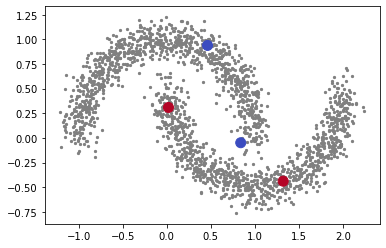

In [12]:
plt.scatter(X_train[:,0], X_train[:,1], color = 'grey', s=5)
plt.scatter(X_train[label_mask,0], X_train[label_mask,1], c = Y_train[label_mask], s=100, cmap = plt.cm.coolwarm)

### Create model and train

In [13]:
??embedder

Object `embedder` not found.


In [14]:
embedder = tfUMAP(
    direct_embedding=False,
    #decoding_method= 'network',
    verbose=True,
    training_epochs=50,
    negative_sample_rate=5,
    min_dist=0,
    optimizer = tf.keras.optimizers.RMSprop(1e-3),
    train_classifier=True,
)

In [15]:
"""embedder = tfUMAP(
    min_dist = 0.0,
    training_epochs=5,
    max_sample_repeats_per_epoch=10,
    train_classifier=True,
    verbose=True,
    dims=[2,1],
    n_components=2,
    target_weight=0.5,
    umap_loss_weight = 1.0
)"""

'embedder = tfUMAP(\n    min_dist = 0.0,\n    training_epochs=5,\n    max_sample_repeats_per_epoch=10,\n    train_classifier=True,\n    verbose=True,\n    dims=[2,1],\n    n_components=2,\n    target_weight=0.5,\n    umap_loss_weight = 1.0\n)'

In [16]:
print(embedder)

tfUMAP(decoding_method='network', negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fb917f415c0>,
       tensorboard_logdir='/tmp/tensorboard/20200706-154924',
       train_classifier=True, training_epochs=50)


In [17]:
z = embedder.fit_transform(X_train_flat, y = Y_train_masked)

tfUMAP(decoding_method='network', negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fb917f415c0>,
       tensorboard_logdir='/tmp/tensorboard/20200706-154924',
       train_classifier=True, training_epochs=50)
Construct fuzzy simplicial set
Mon Jul  6 15:49:26 2020 Finding Nearest Neighbors
Mon Jul  6 15:49:28 2020 Finished Nearest Neighbor Search
Mon Jul  6 15:49:31 2020 Embedding with TensorFlow


Mon Jul  6 15:53:33 2020 Finished embedding


In [18]:
embedder.batch_size

1000

### Plot model output

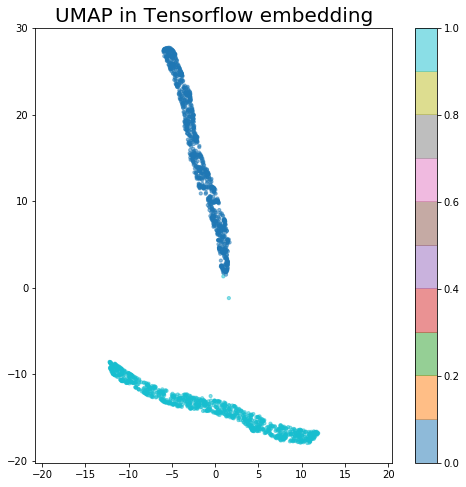

In [19]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=10,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [20]:
layer_names = [i.name for i in embedder.classifier.layers]
layer_names

['flatten_2', 'dense_7', 'dense_8', 'dense_9', 'predictions']

In [21]:
name_weights = [
    (layer.name, [i.numpy().flatten() for i in layer.weights])
    for layer in embedder.classifier.layers
    if len(layer.get_weights()) > 0
]

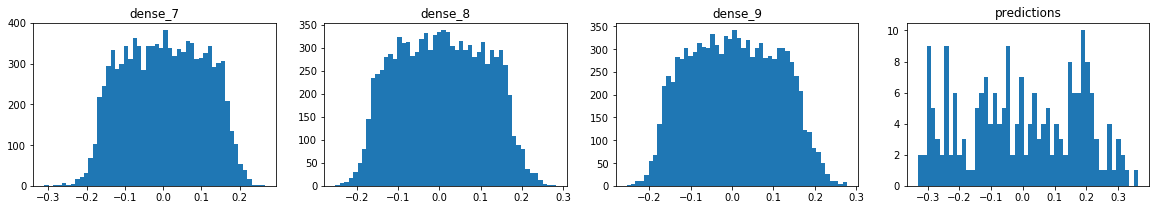

In [22]:
fig, axs = plt.subplots(ncols=len(name_weights), figsize=(20,3))
for axi, (name, weights) in enumerate(name_weights):
    axs[axi].set_title(name)
    axs[axi].hist(np.concatenate(weights).flatten(), bins=50)

In [23]:
###

### plot loss

In [24]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

['umap_loss', 'recon_loss', 'classif_loss', 'classif_acc']
[]


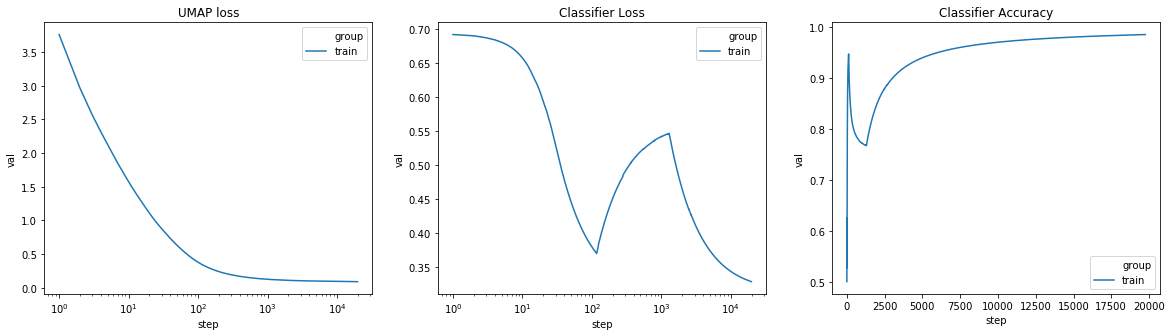

In [25]:
# plot losses
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax, ci=None)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_loss'], ax = ax, ci=None)
ax.set_xscale('log')
ax.set_title('Classifier Loss')

ax = axs[2]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='classif_acc'], ax = ax, ci=None)
#ax.set_xscale('log')
ax.set_title('Classifier Accuracy')
plt.show()

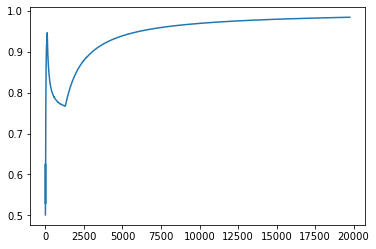

In [26]:
plt.plot(loss_df[loss_df.variable=='classif_acc'].val.values)

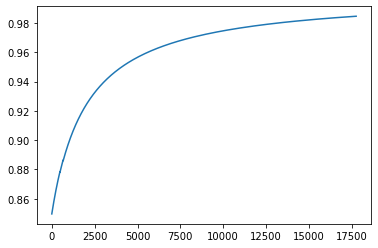

In [27]:
plt.plot(loss_df[loss_df.variable=='classif_acc'].val.values[2000:])

In [28]:
embedder.batch_size

1000

### Plot decision contour

In [29]:
def embed_data(X, batch_size, model):
    """ embed a set of points in X to Z
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    return  np.vstack([
            model.encoder(np.array(X[ (i) * batch_size : (i + 1) * batch_size, :]))
        for i in range(n_batch)
    ])

def make_contour(model):
    x_span = np.linspace(-2, 3, 100)
    y_span = np.linspace(-1, 1.5, 100)
    xx, yy = np.meshgrid(x_span, y_span)
    X_grid = np.array([xx.ravel(), yy.ravel()]).T
    decision_grid = classify_data(X_grid, batch_size = 100, model=model)
    return xx, yy, decision_grid

def classify_data(X, batch_size, model):
    """ Classify a set of points X
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    predictions =   np.vstack([
        model.classifier(
            model.encoder_base(np.array(X[ (i) * batch_size : (i + 1) * batch_size, :]))
        )
        for i in range(n_batch)
    ])
    predictions = tf.nn.softmax(predictions).numpy()
    return  predictions[:,1] - predictions[:,0]

def get_decision_contour(ax, model):
    
    xx, yy, decision_grid = make_contour(model=model)

    ax.contourf(
        xx,
        yy,
        decision_grid.reshape((100, 100)),
        cmap=plt.cm.coolwarm,
        alpha=0.5,
        levels=np.linspace(-1, 1, 10),
    )

    ax.scatter(X_train[:, 0], X_train[:, 1], color = 'grey', alpha = 1, s=5)
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c = Y_labeled, cmap=plt.cm.coolwarm, s=50)
    ax.set_title('Decision contour')
    return ax

W0706 15:53:40.723153 140435964311360 base_layer.py:1790] Layer flatten is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Text(0.5, 1.0, 'Decision contour')

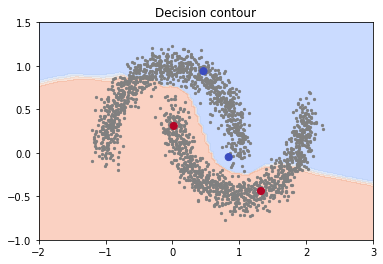

In [30]:
fig, ax = plt.subplots()

z = embed_data(X_validation, 100, model=embedder)
xx, yy, decision_grid = make_contour(model=embedder)
ax.contourf(
        xx,
        yy,
        decision_grid.reshape((100, 100)),
        cmap=plt.cm.coolwarm,
        alpha=0.5,
        levels=np.linspace(-1, 1, 10),
)
ax.scatter(X_train[:, 0], X_train[:, 1], color = 'grey', alpha = 1, s=5)
ax.scatter(X_train[label_mask,0], X_train[label_mask,1], c = Y_train[label_mask], cmap=plt.cm.coolwarm, s=50)
ax.set_title('Decision contour')

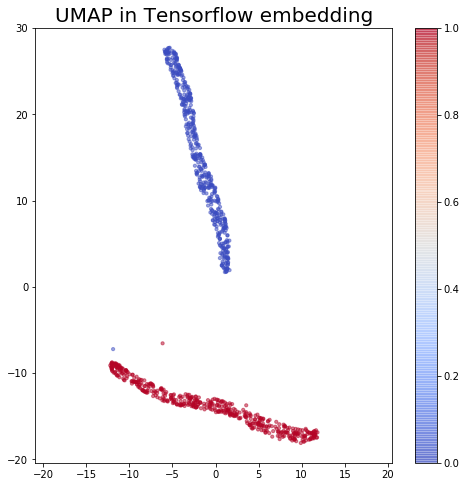

In [31]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_validation.astype(int)[:len(z)],
    cmap="coolwarm",
    s=10,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [32]:
Y_valid_class = classify_data(X_validation, batch_size = 100, model=embedder)

In [33]:
z_train = embedder.embedding_

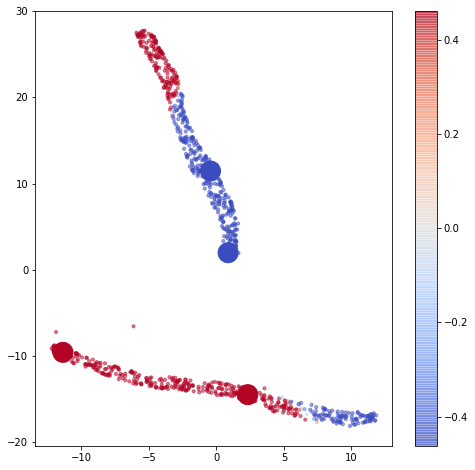

In [34]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_valid_class,
    cmap="coolwarm",
    s=10,
    alpha=0.5,
    rasterized=True,
)

ax.scatter(z_train[label_mask,0], z_train[label_mask,1], c = Y_train[label_mask], cmap=plt.cm.coolwarm, s=400)


plt.colorbar(sc, ax=ax);